In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from pathlib import Path
from regions import CircleSkyRegion
from scipy.stats import norm
from gammapy.data import DataStore
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    FoVBackgroundModel,
    Models,
)
from gammapy.modeling import Fit
from gammapy.maps import Map
from gammapy.estimators import ExcessMapEstimator
from gammapy.datasets import MapDataset

In [106]:
config = AnalysisConfig()
# The config file is now empty, with only a few defaults specified.
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 5}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_selection: [counts, exposure, background, psf, ed

In [107]:
# Selecting the observations
config.observations.datastore = ("../")
# We define the cone search parameters
config.observations.obs_cone.frame = "galactic"
config.observations.obs_cone.lon = "82 deg"
config.observations.obs_cone.lat = "2 deg"
config.observations.obs_cone.radius = "8 deg"

In [108]:
# We want to perform a 3D analysis
config.datasets.type = "3d"

# We want to stack the data into a single reduced dataset
config.datasets.stack = True

# We fix the WCS geometry of the datasets
config.datasets.geom.wcs.skydir = {
    "lon": "82 deg",
    "lat": "2.0 deg",
    "frame": "galactic",
}
config.datasets.geom.wcs.width = {"width": "5 deg", "height": "12 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# We now fix the reconstructed energy axis for the counts map
config.datasets.geom.axes.energy.min = "0.7 TeV"
config.datasets.geom.axes.energy.max = "100 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the true energy axis for the IRF maps (exposure, etc)
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "200 TeV"
config.datasets.geom.axes.energy_true.nbins = 20

# We are going to consider the background only from the IRF
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

#Let's define the fit range:
config.fit.fit_range.min = 0.7 * u.TeV
config.fit.fit_range.max = 100 * u.TeV
config.flux_points.energy = {"min": "0.7 TeV", "max": "100 TeV", "nbins": 10}
config.excess_map.correlation_radius = 0.1 * u.deg

# write down the config as yaml file:
config.write("config.yaml", overwrite=True)

# let's read the saved file:
config = AnalysisConfig.read("config.yaml")
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: ..
        obs_ids: []
        obs_file: null
        obs_cone: {frame: galactic, lon: 82.0 deg, lat: 2.0 deg, radius: 8.0 deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: galactic, lon: 82.0 deg, lat: 2.0 deg}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 12.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 0.7 TeV, max: 100.0 TeV, nbins: 10}
                energy_true: {min: 0.1 TeV, max: 200.0 TeV, nbins: 20}
        map_selection: [counts, exposure, background, ps

In [109]:
# the Analysis() class performs the data analysis:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [110]:
# select the observations
analysis.get_observations()

Fetching observations.
Observations selected: 105 out of 105.
Number of selected observations: 105


In [111]:
# select the observations and fill the datasets
analysis.get_datasets()

Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 31
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 31
No default lower safe energy threshold defined for obs 31
Running FoVBackgroundMaker
Computing dataset for observation 15
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 15
No default lower safe energy threshold defined for obs 15
Running FoVBackgroundMaker
Computing dataset for observation 110
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 110
No default lower safe energy threshold defined for obs 110
Running FoVBackgroundMaker
Computing dataset for observation 22
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 22
No default lower safe energy threshold defined for obs 22
Running FoVBackgrou

In [112]:
# let's inspect the main properties of the stacked datasets:
print(analysis.datasets["stacked"])

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 364293 
  Total background counts         : 364293.09
  Total excess counts             : -0.09

  Predicted counts                : 364293.00
  Predicted background counts     : 364293.09
  Predicted excess counts         : nan

  Exposure min                    : 1.56e+08 m2 s
  Exposure max                    : 1.04e+12 m2 s

  Number of total bins            : 1500000 
  Number of fit bins              : 700000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Computing excess maps.


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

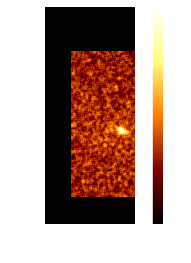

In [113]:
counts = analysis.datasets["stacked"].counts
counts.smooth("0.05 deg").plot_interactive()

analysis.get_excess_map()
analysis.excess_map["sqrt_ts"].plot(add_cbar=True)